<a href="https://colab.research.google.com/github/Faisal-Al-Mamun/Pneumonia_Detection_From_Chest_X-Ray_Images_Using_CNN/blob/main/Pneumonia_Detection_from_Chest_X_Ray_Images_using_CNN%2C_Tensorflow_2_0%2C_Keras_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Loading Data on Google Colab from Google Drive

In [ ]:
!cp -r "/content/drive/My Drive/Colab Notebooks/Chest X-Ray Images (Pneumonia) Dataset.zip" "/content/"

In [ ]:
!unzip 'Chest X-Ray Images (Pneumonia) Dataset.zip'

Dataset Downloaded from Kaggle
Link:- https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

### Importing Libraries

In [ ]:
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)


device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.7.0
Found GPU at: /device:GPU:0


In [ ]:
# additional imports

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.preprocessing import image
from glob import glob

### Data Augmentation & Data Loading

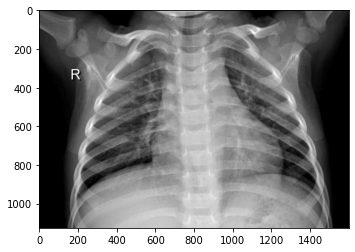

In [ ]:
# look at an image
plt.imshow(image.load_img('/content/Chest X-Ray Images (Pneumonia) Dataset/train/NORMAL/IM-0125-0001.jpeg'))
plt.show()

In [ ]:
# useful for getting number of files
TRAIN_IMG_COUNT = glob('/content/Chest X-Ray Images (Pneumonia) Dataset/train' + '/*/*.jpeg')
TEST_IMG_COUNT = glob('/content/Chest X-Ray Images (Pneumonia) Dataset/test' + '/*/*.jpeg')

batch_size = 32

print(len(TRAIN_IMG_COUNT))
print(len(TEST_IMG_COUNT))
print(int(np.ceil(len(TRAIN_IMG_COUNT) / batch_size)))

5216
624
163


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range=10,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    horizontal_flip=False,
                                    vertical_flip=False
                                   )

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('/content/Chest X-Ray Images (Pneumonia) Dataset/train',
                                                 target_size = (180, 180),
                                                 color_mode="grayscale",
                                                 batch_size = 32,
                                                 class_mode='binary')

Found 5216 images belonging to 2 classes.


In [ ]:
test_set = test_datagen.flow_from_directory('/content/Chest X-Ray Images (Pneumonia) Dataset/test',
                                            target_size = (180, 180),
                                            color_mode="grayscale",
                                            batch_size = 32,
                                            shuffle=False,
                                            class_mode='binary')

Found 624 images belonging to 2 classes.


### Correction for data imbalance

In [ ]:
COUNT_NORMAL = len(glob('/content/Chest X-Ray Images (Pneumonia) Dataset/train' + '/NORMAL/*.jpeg'))
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len(glob('/content/Chest X-Ray Images (Pneumonia) Dataset/train' + '/PNEUMONIA/*.jpeg'))
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

#Class Labeling
print(training_set.class_indices)


Normal images count in training set: 1341
Pneumonia images count in training set: 3875
{'NORMAL': 0, 'PNEUMONIA': 1}


In [ ]:
weight_for_0 = (1 / COUNT_NORMAL)*(len(TRAIN_IMG_COUNT))/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(len(TRAIN_IMG_COUNT))/2.0

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


### CNN Model

In [ ]:
i = Input(shape=(180, 180, 1))

x = Conv2D(64, (3, 3), activation='relu', padding='same')(i)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.2)(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.2)(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.2)(x)

#x = GlobalMaxPooling2D()(x)
x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

### Model Compailation and Model Fitting

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
r = model.fit(training_set,
              validation_data = test_set,
              epochs = 10,
              steps_per_epoch = int(np.ceil(len(TRAIN_IMG_COUNT) / batch_size)),
              validation_steps = int(np.ceil(len(TEST_IMG_COUNT) / batch_size)),
               class_weight=class_weights)

Epoch 1/10
163/163 [==============================] - 94s 577ms/step - loss: 0.3620 - accuracy: 0.8349 - val_loss: 0.3687 - val_accuracy: 0.8686
Epoch 2/10
163/163 [==============================] - 93s 567ms/step - loss: 0.2801 - accuracy: 0.8832 - val_loss: 0.3403 - val_accuracy: 0.8574
Epoch 3/10
163/163 [==============================] - 93s 567ms/step - loss: 0.2474 - accuracy: 0.8924 - val_loss: 0.3316 - val_accuracy: 0.8910
Epoch 4/10
163/163 [==============================] - 93s 567ms/step - loss: 0.2150 - accuracy: 0.9130 - val_loss: 0.2984 - val_accuracy: 0.8974
Epoch 5/10
163/163 [==============================] - 93s 567ms/step - loss: 0.2104 - accuracy: 0.9179 - val_loss: 0.2935 - val_accuracy: 0.8894
Epoch 6/10
163/163 [==============================] - 93s 568ms/step - loss: 0.1957 - accuracy: 0.9268 - val_loss: 0.3520 - val_accuracy: 0.8990
Epoch 7/10
163/163 [==============================] - 93s 567ms/step - loss: 0.1788 - accuracy: 0.9304 - val_loss: 0.3745 - val_ac

### Loss and Accuracy Graph

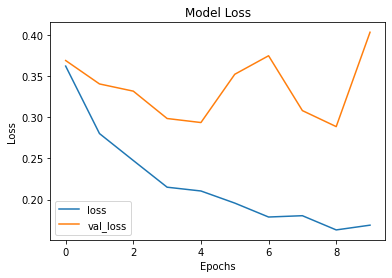

In [ ]:
# Plot what's returned by model.fit() / model.fit_generator()
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

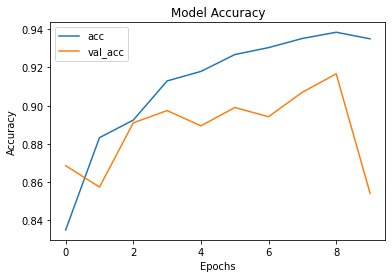

In [ ]:
# Plot the accuracy too
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

### Model Saving and Model Summary

In [ ]:
# Saving Trained Model
model.save('Pneumonia Detection from Chest X-Ray Images.h5') # creates a HDF5 file

In [ ]:
#Loading previously trained model

#from keras.models import load_model

model= tf.keras.models.load_model('Pneumonia Detection from Chest X-Ray Images.h5')

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 1)]     0         
                                                                 
 conv2d_48 (Conv2D)          (None, 180, 180, 64)      640       
                                                                 
 conv2d_49 (Conv2D)          (None, 180, 180, 64)      36928     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 90, 90, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 90, 90, 128)       73856     
                                                                 
 conv2d_51 (Conv2D)          (None, 90, 90, 128)       147584    
                                                           

### Single Prediction Check

In [ ]:
import numpy as np
from keras.preprocessing import image


test_image = image.load_img('/content/Chest X-Ray Images (Pneumonia) Dataset/val/PNEUMONIA/person1950_bacteria_4881.jpeg', target_size = (180, 180),color_mode='grayscale')
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image,axis = 0)

result = model.predict(test_image)

print(training_set.class_indices) 

if result[0][0] == 1:
    prediction = 'PNEUMONIA'
else:
    prediction = 'NORMAL'
    
print(prediction) 
print(result[0][0]) 

{'NORMAL': 0, 'PNEUMONIA': 1}
PNEUMONIA
1.0


### F1 Score and Confusion Matrix

In [ ]:

test_steps_per_epoch = np.math.ceil(test_set.samples / test_set.batch_size)

predictions = model.predict(test_set, steps=test_steps_per_epoch)


# Get most likely class

predicted_classes = [1 * (x[0]>=0.5) for x in predictions]


print(predicted_classes)



[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys())

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(true_classes, predicted_classes, target_names=class_labels))   

              precision    recall  f1-score   support

      NORMAL       0.94      0.65      0.77       234
   PNEUMONIA       0.82      0.98      0.89       390

    accuracy                           0.85       624
   macro avg       0.88      0.81      0.83       624
weighted avg       0.87      0.85      0.85       624



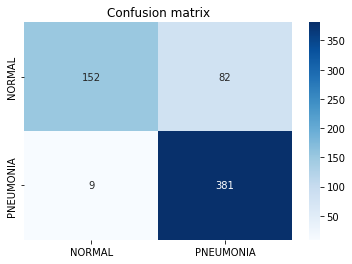

In [ ]:
import seaborn as sn

#sn.set(font_scale=0.9)

class_names = ['NORMAL', 'PNEUMONIA']

CM = confusion_matrix(true_classes, predicted_classes)

ax = plt.axes()
sn.heatmap(CM, annot=True, 
           cmap= "Blues", 
           annot_kws={"size": 10},
            fmt='', 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()